In [1]:
import cv2 as cv
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

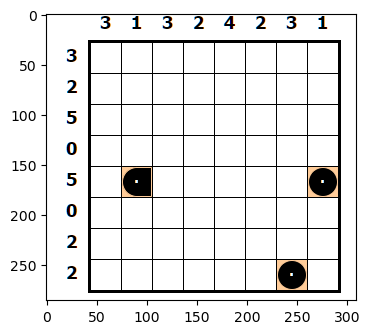

In [2]:
#Loe pilt
img_rgb = cv.imread('images/puzzle8_2.PNG')
# Mustvalge igaks juhuks
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(4,4))
plt.imshow(img_rgb)

In [3]:
#meetod matchTemplate kasutades ruutude asukohtade leidmiseks
#puzzle_rgb-pilt, folder - kaust(olenevalt suuruses images kausta sees olev kaust), templateFile - template mida kasutatakse
# allFound - järjend, kus kõik asukohad kirjas
def findTemplate(puzzle_rgb,templateFile,version,allFound):
    template = cv.imread('images/' + 'square'+templateFile+'/' + version + '.PNG')
    templates = []
    #lisame template 4 erinevat pidi, et kõikvõimalikud leitakse
    templates.append(template)
    templates.append(cv.rotate(template, cv.ROTATE_90_CLOCKWISE))
    templates.append(cv.rotate(template, cv.ROTATE_90_COUNTERCLOCKWISE))
    templates.append(cv.rotate(template, cv.ROTATE_180))
    w, h = template.shape[::-2]
    for i in range(len(templates)):
        res = cv.matchTemplate(puzzle_rgb,templates[i], cv.TM_CCOEFF_NORMED)
        #0.82 hetkel maksimaalne threshold, mis leiab pea alati mingi versiooni lauast
        # kõrgema korral enamasti mingeid ruutusid ei leia
        threshold = 0.96
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            alreadyThere = False
            for found in allFound:
                #iga leitud asukoha korral kontrollime ega tegemist pole juba leitud ruuduga
                if abs(found[0] - pt[0]) < 10 and abs(found[1]-pt[1]) < 10:
                    alreadyThere = True
                    break
            if not alreadyThere:
                #kui pole varem leitud ruut, lisame vastavalt nimele selle allFoundi
                #'None' template ehk hetkel tühi ruut on None tüüpi
                if templateFile == 'None':
                    allFound.append((pt[0],pt[1],None))
                #2 korral ehk poolringi taolisel ruudul on 4 erinevat varianti, nii et anname vastavalt järjekorrale õige variandi
                elif templateFile == '2':
                    allFound.append((pt[0],pt[1],int(templateFile)*(i+1)))
                else:
                    allFound.append((pt[0],pt[1],int(templateFile)))
                # rectangle(pilt, algusnurk (koordinaadid), lõppnurk, värv (BGR), joone paksus)
                cv.rectangle(puzzle_rgb, pt, (pt[0]+w, pt[1]+h), (0,255,255), 1)

In [4]:
#meetod kõikide ruutude leidmiseks ja kontrolliks kas pikkus on vastav (variandid 6x6,8x8,10x10,15x15)
def getPuzzle(img_rgb):
    allFound = []
    sizes = [6,8,10,15]
    templates = ['0','2','1','5','None']
    for template in templates:
        for i in range(1,6):
            img_copy = img_rgb.copy()
            findTemplate(img_copy,template,'Version' + str(i),allFound)
    for i in allFound:
        if i[2] is not None:
            print(i)
    print(len(allFound))
    for size in sizes:
        if len(allFound) == size**2 or len(allFound) + 1 == size**2:
            return allFound
    return None

In [5]:
currentPuzzle = getPuzzle(img_rgb)

(75, 154, 6)
(260, 150, 1)
(229, 243, 1)
64


In [6]:
#meetod ruutude sorteerimiseks ja seejärel rea ja veeru kaupa täpsustamiseks asukohta, et ühtlased read ja veerud saada
def levelRowsAndColumns(allFound):
    sortedSquares = sorted(allFound, key=lambda element: (element[1]))
    for i in range(len(sortedSquares)):
        if 0 < sortedSquares[i][1] - sortedSquares[i-1][1] < 20:
            sortedSquares[i] = (sortedSquares[i][0],sortedSquares[i-1][1],sortedSquares[i][2])
    sortedSquares = sorted(sortedSquares, key=lambda element: (element[0]))
    for i in range(len(sortedSquares)):
        if 0 < sortedSquares[i][0] - sortedSquares[i-1][0] < 20:
            sortedSquares[i] = (sortedSquares[i-1][0],sortedSquares[i][1],sortedSquares[i][2])
    sortedSquares = sorted(sortedSquares, key=lambda element: (element[1],element[0]))
    
    return sortedSquares

In [7]:
def fixMissingOne(allFound):

    counts_x = {}
    counts_y = {}

    for t in allFound:
        if t[0] in counts_x:
            counts_x[t[0]] += 1
        else:
            counts_x[t[0]] = 1

        if t[1] in counts_y:
            counts_y[t[1]] += 1
        else:
            counts_y[t[1]] = 1
            
    min_count_x = min(counts_x.values())
    
    outliers_x = [k for k, v in counts_x.items() if v == min_count_x]
    
    min_count_y = min(counts_y.values())

    outliers_y = [k for k, v in counts_y.items() if v == min_count_y]
    if min_count_x + 1 == max(counts_x.values()) and min_count_y + 1 == max(counts_y.values()) and len(outliers_x) == 1 and len(outliers_y) == 1:
        allFound.append((outliers_x[0],outliers_y[0],None))
        allFound = sorted(allFound, key=lambda element: (element[1],element[0]))
        return allFound
    
    return None

In [8]:
#lõplikusse järjendite järjendisse viimine
def coordinatesToArray(allFound):
    if allFound is None:
        return
    
    correct = None
    #fikseerime numbrid
    allFound = levelRowsAndColumns(allFound)
    print(allFound[43])
    allFound.pop(43)
    length = len(allFound)
    #leiame rea suuruse
    rowLength = -1
    for i in range(1,16):
        #kui pikkus on arvu ruut, on reapikkus leitud
        if length == i**2:
            rowLength = i
            break
        #kui üks puudu, proovime lisada tühja ruudu
        if length + 1 == i**2:
            allFound = fixMissingOne(allFound)
            if allFound is not None:
                rowLength = i
                break
            else:
                return None
    if rowLength == -1:
        return None
    fullMatrix = []
    #viime ridadesse vastava reapikkuse kaupa
    for i in range(rowLength):
        row = [t[2] for t in allFound[i*rowLength:i*rowLength+rowLength]]
        fullMatrix.append(row)
    return fullMatrix

In [9]:
def findNumbers(img):
    allNumbers = []
    for i in range(10):
        template = cv.imread('images/numbers/' + str(i) + '.PNG')
        res = cv.matchTemplate(img,template, cv.TM_CCOEFF_NORMED)
        threshold = 0.9
        loc = np.where(res >= threshold)
        w, h = template.shape[::-2]
        for pt in zip(*loc[::-1]):
            alreadyThere = False
            for found in allNumbers:
                if abs(found[0] - pt[0]) < 10 and abs(found[1]-pt[1]) < 10:
                    alreadyThere = True
                    break
            if not alreadyThere:
                allNumbers.append((pt[0],pt[1],i))
                # rectangle(pilt, algusnurk (koordinaadid), lõppnurk, värv (BGR), joone paksus)
                cv.rectangle(img, pt, (pt[0]+w, pt[1]+h), (0,255,255), 1)
    allNumbers = levelRowsAndColumns(allNumbers)
    side = [x[2] for x in allNumbers[:int(len(allNumbers)/2)]]
    up = [x[2] for x in allNumbers[int(len(allNumbers)/2):]]
    return up,side

In [10]:
print(coordinatesToArray(currentPuzzle))

(136, 182, None)
fine
136 182 None
[[None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None], [None, 6, None, None, None, None, None, 1], [None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None], [None, None, None, None, None, None, 1, None]]


In [11]:
findNumbers(img_rgb)

([0, 5, 0, 2, 2], [2, 2, 3, 2, 5])